In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys

sys.path += ['..']

#%aimport GAN

画像の読み込み

In [52]:
import os

drive = '/Users/admin/PycharmProjects/GAN/DeepNeuralNet/GAN/imgs/'

path = [os.path.join(drive, f) for f in os.listdir(drive) if '.png' in f]
imgs = np.array([cv2.imread(p, False).astype('float32') for p in path])
imgs = (imgs.reshape(*imgs.shape, 1) - 127.5) / 127.5

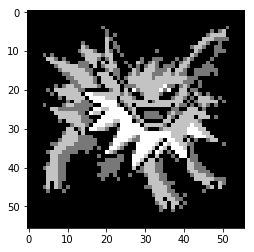

In [53]:
plt.imshow(imgs[0][:,:,0], cmap='gray')

In [54]:
imgs.shape

(239, 56, 56, 1)

画像の複製

In [55]:
params = {
    'rotation_range': 20,
    'width_shift_range': 0.1
}
datagen = image.ImageDataGenerator(**params)


# ミニバッチを生成するジェネレーターを作成する。
gen = datagen.flow(imgs, batch_size= imgs.shape[0])
for _ in range(50):
    imgs = np.vstack([imgs, next(gen)])

In [41]:
imgs.shape

(12189, 56, 56, 1)

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout
import math
import numpy as np

def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5,
                            subsample=(2, 2),
                            border_mode='same',
                            input_shape=(56, 56, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    comp =  model.compile(optimizer="adam",loss = "mse")
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.add(Activation('sigmoid'))
    return model


def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[:, :, 0]
    return combined_image



In [73]:
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

BATCH_SIZE = 128
NUM_EPOCH = 1
GENERATED_IMAGE_PATH = 'generated_images/' # 生成画像の保存先

def train():
    
    X_train = imgs
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    discriminator = discriminator_model()
    d_opt = Adam(lr=1e-5, beta_1=0.1)
    discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

    # generator+discriminator （discriminator部分の重みは固定）
    discriminator.trainable = False
    generator = generator_model()
    dcgan = Sequential([generator, discriminator])
    g_opt = Adam(lr=2e-4, beta_1=0.5)
    dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    print('Number of batches:', num_batches)
    for epoch in range(NUM_EPOCH):

        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)

            # 生成画像を出力
            if index % 500 == 0:
                image = combine_images(generated_images)
                image = image*127.5 + 127.5
                if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
                Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

            # discriminatorを更新
            X = np.concatenate((image_batch, generated_images))
            y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)

            # generatorを更新
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))

        generator.save_weights('generator.h5')
        discriminator.save_weights('discriminator.h5')

train()

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(56, 56, 1..., strides=(2, 2), padding="same")`
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  if sys.path[0] == '':
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

Number of batches: 95
(128, 56, 56, 1) (672, 616)
Instructions for updating:
Use tf.cast instead.


/Users/admin/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, batch: 0, g_loss: 0.637998, d_loss: 0.708882
epoch: 0, batch: 1, g_loss: 0.678371, d_loss: 0.716459
epoch: 0, batch: 2, g_loss: 0.713591, d_loss: 0.689126
epoch: 0, batch: 3, g_loss: 0.760097, d_loss: 0.657743
epoch: 0, batch: 4, g_loss: 0.782966, d_loss: 0.632794
epoch: 0, batch: 5, g_loss: 0.787517, d_loss: 0.631466
epoch: 0, batch: 6, g_loss: 0.782282, d_loss: 0.640126
epoch: 0, batch: 7, g_loss: 0.768804, d_loss: 0.664096
epoch: 0, batch: 8, g_loss: 0.743078, d_loss: 0.678469
epoch: 0, batch: 9, g_loss: 0.735716, d_loss: 0.678797
epoch: 0, batch: 10, g_loss: 0.725261, d_loss: 0.650343


KeyboardInterrupt: 